In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

import rdkit
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize

import mordred
from mordred import Calculator, descriptors

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [7]:
# Same utility function from training

def standardize_molecule(mol):
    """Applies standardization to an RDKit Mol object."""
    try:
        # Remove salts and fragments
        cleaner = rdMolStandardize.Cleanup(mol)
        # Normalize functional groups
        normalizer = rdMolStandardize.Normalize(cleaner)
        # Reionize to standard charge states
        reionizer = rdMolStandardize.Reionize(normalizer)
        return reionizer
    except:
        return mol # return original if fails

In [8]:
# Load saved model and preprocessing artifacts

print("Loading model and preprocessing data...")
try:
    model_data = joblib.load('svm_mordred_model.pkl')
except FileNotFoundError:
    print("Error: 'svm_mordred_model.pkl' not found.")
    print("Please run the 'train.py' script first to create this file.")
    exit()

# Unpack the saved artifacts
svm_model = model_data['model']
scaler = model_data['scaler']
training_columns = model_data['training_columns']
training_means = model_data['training_means']

# Re-initialize the calculator
calc = mordred.Calculator(descriptors, ignore_3D=True)

Loading model and preprocessing data...


In [19]:

# testing function

def test_on_new_data(file_path, dataset_name):
    
    """Loads an external dataset and evaluates the model."""
    
    print(f"\nTesting on {dataset_name} ({file_path})...")
    
    try:
        new_df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"  Error: File not found at {file_path}")
        return
        
    print(f" Loaded {len(new_df)} molecules")
    
    # Standardize SMILES
    mols = [Chem.MolFromSmiles(smi) for smi in new_df['SMILES']]
    std_mols = [standardize_molecule(mol) if mol is not None else None for mol in mols]
    new_df['clean_smiles'] = [Chem.MolToSmiles(mol, canonical=True) if mol is not None else None for mol in std_mols]
    
    original_count = len(new_df)
    new_df = new_df.dropna(subset=['clean_smiles']).reset_index(drop=True)
    if not 'LogS' in new_df.columns:
        print("  Error: 'LogS' column not found in the dataset for evaluation.")
        return
        
    print(f"  {len(new_df)} valid molecules after standardization (removed {original_count - len(new_df)})")
    
    # Calculate Mordred descriptors
    mols_for_mordred = [Chem.MolFromSmiles(smi) for smi in new_df['clean_smiles']]
    mols_for_mordred = [mol for mol in mols_for_mordred if mol is not None]

    if len(mols_for_mordred) < len(new_df):
        new_df = new_df.iloc[:len(mols_for_mordred)]
        print(f"  Note: Further filtering required. {len(new_df)} molecules remaining.")
    
    descriptors = calc.pandas(mols_for_mordred)
    
    # Clean descriptors 
    descriptors = descriptors.select_dtypes(include=[np.number])
    descriptors = descriptors.replace([np.inf, -np.inf], np.nan)
    
    # Align features with training set 
    X_new = descriptors.reindex(columns=training_columns) 
    
    # Impute NaNs 
    X_new_imputed = X_new.fillna(training_means) 
    
    # Scale 
    X_new_scaled = scaler.transform(X_new_imputed)
    
    # Predict
    predictions = svm_model.predict(X_new_scaled)
    new_df['Predicted_LogS'] = predictions
    
    # Evaluate
    mae = mean_absolute_error(new_df['LogS'], predictions)
    r2 = r2_score(new_df['LogS'], predictions)
    rmse = np.sqrt(mean_squared_error(new_df['LogS'], predictions))
    
    print(f" RESULTS:")
    print(f"  MAE:  {mae:.3f} LogS units")
    print(f"  R²:   {r2:.3f}")
    print(f"  RMSE: {rmse:.3f}")
    
    return mae, r2, new_df['LogS'], predictions

In [ ]:
import os
save_dir = "./plots"
os.makedirs(save_dir, exist_ok=True)

In [20]:
def generate_and_save_plot(actual, predicted, r2, mae, dataset_name):
    """Generates the scatter plot and saves it to a file."""
    
    plt.figure(figsize=(8, 6))
    
    # Scatter plot
    plt.scatter(actual, predicted, alpha=0.6, s=30, color='darkorange', label="Predictions")
    
    # Add the 'perfect prediction' line (y=x)
    min_val = min(actual.min(), predicted.min())
    max_val = max(actual.max(), predicted.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label="Ideal (y=x)")
    
    plt.xlabel('Actual LogS')
    plt.ylabel('Predicted LogS')
    plt.title(f'{dataset_name}\nActual vs. Predicted (R² = {r2:.3f}, MAE = {mae:.3f})')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Define the filename and save the figure
    filename = os.path.join(save_dir, f"results_{dataset_name.replace(' ', '_')}_plot.png")
    
    plt.savefig(filename, dpi=300)
    print(f"  Plot saved successfully as: {filename}")

    plt.show()
    
    plt.close()
    
    print(f"  Plot saved successfully as: {filename}")

--- Starting External Model Evaluation ---

Testing on Dataset 1 (./data/challenge_data_1.csv)...
 Loaded 1763 molecules


[21:31:27] Initializing MetalDisconnector
[21:31:27] Running MetalDisconnector
[21:31:27] Initializing Normalizer
[21:31:27] Running Normalizer
[21:31:27] Initializing Normalizer
[21:31:27] Running Normalizer
[21:31:27] Initializing MetalDisconnector
[21:31:27] Running MetalDisconnector
[21:31:27] Initializing Normalizer
[21:31:27] Running Normalizer
[21:31:27] Initializing Normalizer
[21:31:27] Running Normalizer
[21:31:27] Initializing MetalDisconnector
[21:31:27] Running MetalDisconnector
[21:31:27] Initializing Normalizer
[21:31:27] Running Normalizer
[21:31:27] Initializing Normalizer
[21:31:27] Running Normalizer
[21:31:27] Initializing MetalDisconnector
[21:31:27] Running MetalDisconnector
[21:31:27] Initializing Normalizer
[21:31:27] Running Normalizer
[21:31:27] Initializing Normalizer
[21:31:27] Running Normalizer
[21:31:27] Initializing MetalDisconnector
[21:31:27] Running MetalDisconnector
[21:31:27] Initializing Normalizer
[21:31:27] Running Normalizer
[21:31:27] Initializ

  1763 valid molecules after standardization (removed 0)
/home/zenab-khan/miniconda3/envs/CADDSeminar/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
 RESULTS:
  MAE:  1.083 LogS units
  R²:   -0.930
  RMSE: 1.342
  Plot saved successfully as: results_Dataset_1_plot.png


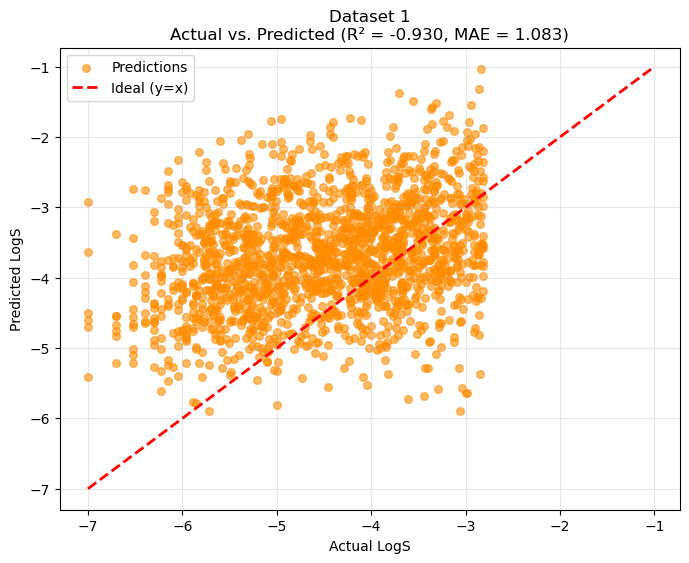

  Plot saved successfully as: results_Dataset_1_plot.png

Testing on Dataset 2 (./data/challenge_data_2.csv)...
 Loaded 2173 molecules


[21:34:23] Initializing MetalDisconnector
[21:34:23] Running MetalDisconnector
[21:34:23] Initializing Normalizer
[21:34:23] Running Normalizer
[21:34:23] Initializing Normalizer
[21:34:23] Running Normalizer
[21:34:23] Initializing MetalDisconnector
[21:34:23] Running MetalDisconnector
[21:34:23] Initializing Normalizer
[21:34:23] Running Normalizer
[21:34:23] Initializing Normalizer
[21:34:23] Running Normalizer
[21:34:23] Initializing MetalDisconnector
[21:34:23] Running MetalDisconnector
[21:34:23] Initializing Normalizer
[21:34:23] Running Normalizer
[21:34:23] Initializing Normalizer
[21:34:23] Running Normalizer
[21:34:23] Initializing MetalDisconnector
[21:34:23] Running MetalDisconnector
[21:34:23] Initializing Normalizer
[21:34:23] Running Normalizer
[21:34:23] Initializing Normalizer
[21:34:23] Running Normalizer
[21:34:23] Initializing MetalDisconnector
[21:34:23] Running MetalDisconnector
[21:34:23] Initializing Normalizer
[21:34:23] Running Normalizer
[21:34:23] Initializ

  2173 valid molecules after standardization (removed 0)
  Note: Further filtering required. 2170 molecules remaining.


[21:34:33] Can't kekulize mol.  Unkekulized atoms: 8 19
[21:34:33] Can't kekulize mol.  Unkekulized atoms: 9 19
[21:34:33] Can't kekulize mol.  Unkekulized atoms: 10 22


/home/zenab-khan/miniconda3/envs/CADDSeminar/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
 RESULTS:
  MAE:  3.979 LogS units
  R²:   -32.387
  RMSE: 4.102
  Plot saved successfully as: results_Dataset_2_plot.png


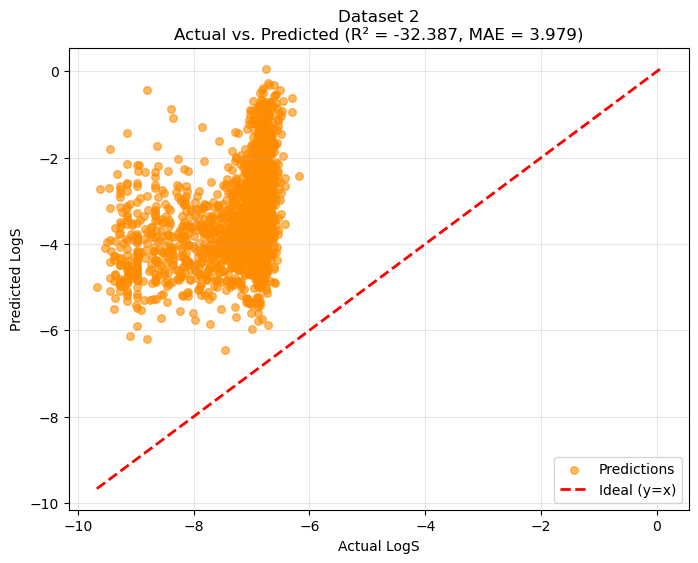

  Plot saved successfully as: results_Dataset_2_plot.png

 Evaluation complete.


In [22]:
# Run the tests

if __name__ == "__main__":
    print("--- Starting External Model Evaluation ---")
    
    mae1, r21, actual1, predicted1 = test_on_new_data(
        "./data/challenge_data_1.csv", 
        "Dataset 1", 
    )
    generate_and_save_plot(actual1, predicted1, r21, mae1, "Dataset 1")
    
    mae2, r22, actual2, predicted2 = test_on_new_data(
        "./data/challenge_data_2.csv", 
        "Dataset 2", 
    )
    generate_and_save_plot(actual2, predicted2, r22, mae2, "Dataset 2")

    print("\n Evaluation complete.")